# Deep Learning Project 3: Adversarial Attacks with FGSM
This notebook demonstrates how to evaluate a pretrained ResNet-34 model on a subset of ImageNet and generate adversarial examples using the Fast Gradient Sign Method (FGSM).

## Step 1: Imports and Device Setup
We begin by importing required libraries and setting up the GPU device.

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



## Step 2: Define Parameters and Transformations


In [ ]:
DATASET_PATH = './TestDataSet'
LABEL_MAP_PATH = './TestDataSet/labels_list.json'  # assumed to be provided
BATCH_SIZE = 16
EPSILON = 0.02
SAVE_PATH = './adversarial_test_set_1'

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
unnormalize = transforms.Normalize(
    mean=(-mean_norms / std_norms).tolist(),
    std=(1.0 / std_norms).tolist()
)


In [ ]:
from torchvision.datasets import ImageFolder

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        # 标准 ImageFolder 的返回值
        image, label = super().__getitem__(index)
        # 拿到该样本的原始路径
        path = self.samples[index][0]
        return image, label, path

## Step 3: Load Dataset and Label Mapping

In [ ]:
# dataset = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transform)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
dataset = ImageFolderWithPaths(root=DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

with open(LABEL_MAP_PATH) as f:
    raw_list = json.load(f)
    idx_to_label = {}
    for item in raw_list:
        index, label = item.split(": ", 1)
        idx_to_label[str(index)] = label.strip()


index_to_name = {}
for entry in raw_list:
    idx_str, class_name = entry.split(": ", 1)
    index_to_name[int(idx_str)] = class_name




## Step 4: Load Pretrained ResNet-34

In [ ]:
model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Step 5: Define FGSM Attack Function

In [ ]:
def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    outputs = model(image)
    loss = nn.CrossEntropyLoss()(outputs, label)
    model.zero_grad()
    loss.backward()
    grad = image.grad.data
    adv_image = image + epsilon * grad.sign()
    adv_image = torch.clamp(adv_image, 0, 1)
    return adv_image.detach()

def fgsm_attack_1(image, label, model, epsilon, min_val=0, max_val=1):
    """
    Perform FGSM attack on the input image.

    Args:
        image: input image (tensor)
        label: true label (tensor)
        model: target model
        epsilon: attack strength
        min_val: minimum pixel value
        max_val: maximum pixel value

    Returns:
        adversarial image (tensor)
    """
    original_image = image.clone().detach()
    image = original_image.clone().detach().requires_grad_(True)

    outputs = model(image)
    loss = nn.CrossEntropyLoss()(outputs, label)

    model.zero_grad()
    loss.backward()

    grad = image.grad.data
    adv_image = image + epsilon * grad.sign()
    adv_image = torch.clamp(adv_image, min_val, max_val).detach()

    return adv_image


In [ ]:
# the visualization
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 可视化函数：对抗图失败样例
def visualize_attack_failure(orig_img, adv_img, noise, adv_logits, idx_to_label, true_label_idx, index_to_name, epsilon=EPSILON, save_path='./viz_pictures'):
    def denorm(img):  # Tensor [3,H,W] -> np.array
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img.detach().permute(1, 2, 0).cpu().numpy()
        img = std * img + mean
        return np.clip(img, 0, 1)

    # verify the L infity
    raw_orig = unnormalize(orig_img)
    raw_adv = unnormalize(adv_img)
    linf_dist = torch.max((raw_adv - raw_orig).abs()).item()
    # print(f"L∞ distance = {linf_dist:.5f}")
    # assert linf_dist <= epsilon + 1e-6, "L∞ constraint violated!"

    probs = F.softmax(adv_logits, dim=0)
    top5_probs, top5_indices = probs.topk(5)
    top5_labels = [idx_to_label.get(str(i.item()), str(i.item())) for i in top5_indices]

    fig, axs = plt.subplots(1, 4, figsize=(14, 4))

    axs[0].imshow(denorm(orig_img))
    axs[0].set_title(index_to_name.get(true_label_idx, f"Class {true_label_idx}"))
    axs[0].axis('off')

    axs[1].imshow(denorm(adv_img))
    axs[1].set_title("Adversarial")
    axs[1].axis('off')

    axs[2].imshow(denorm(noise))
    axs[2].set_title("Noise")
    axs[2].axis('off')

    axs[3].barh(top5_labels[::-1], top5_probs.detach().cpu().numpy()[::-1] * 100)
    axs[3].set_title("Predictions")
    axs[3].set_xlabel("Confidence")
    axs[3].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [ ]:
# save methods
def save_flat_adversarial_images(images, save_path, start_idx=0):
    os.makedirs(save_path, exist_ok=True)
    for i, image in enumerate(images):
        img = unnormalize(image).clamp(0, 1)
        save_image(img, os.path.join(save_path, f"img_{start_idx + i:04d}.png"))

def save_structured_adversarial_images(images, batch_paths, original_root, structured_root):
    for img, path in zip(images, batch_paths):
        rel_path = os.path.relpath(path, start=original_root)
        save_path = os.path.join(structured_root, rel_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        save_image(unnormalize(img).clamp(0, 1), save_path)

## Step 6: Evaluation and Visualization

In [ ]:
VIZ_PATH = './viz_pictures'

def save_adversarial_dataset(images, save_path):
    os.makedirs(save_path, exist_ok=True)
    for i, image in enumerate(images):
        img = unnormalize(image).clamp(0, 1)
        save_image(img, os.path.join(save_path, f"img_{i:04d}.png"))
    print(f"Adversarial dataset saved at {save_path}")


def evaluate(
    model,
    dataloader,
    adversarial=False,
    idx_to_label=None,
    structured_save=False,
    original_root=None,
    structured_save_root=None,
    SAVE_PATH="./adversarial_flat",
    EPSILON=0.02,
    attack_function=None,
):
    correct_1 = 0
    correct_5 = 0
    total = 0
    all_adv_images = []
    adv_image_count = 0
    failures_shown = 0

    model.eval()

    with torch.no_grad() if not adversarial else torch.enable_grad():
        for i, (images, labels, paths) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            imagenet_labels = labels + 401  # or replace with mapped labels

            if adversarial and attack_function is not None:
                # clone the img before attack
                original_images_before_attack = images.clone().detach().cpu()
                # attack the image
                images = attack_function(model=model, image=images, label=imagenet_labels, epsilon=EPSILON)
                # Save adversarial images
                if structured_save:
                  for img, orig_path in zip(images.cpu(), paths):
                      rel_path = os.path.relpath(orig_path, start=original_root)
                      save_path = os.path.join(structured_save_root, rel_path)
                      os.makedirs(os.path.dirname(save_path), exist_ok=True)
                      save_image(unnormalize(img).clamp(0, 1), save_path)
                else:
                    save_flat_adversarial_images(images.cpu(), SAVE_PATH, start_idx=adv_image_count)
                    adv_image_count += images.size(0)

                all_adv_images.append(images.cpu())

            # Model prediction
            outputs = model(images)
            _, pred = outputs.topk(5, 1, True, True)
            correct = pred.eq(imagenet_labels.view(-1, 1).expand_as(pred))
            correct_1 += correct[:, 0].sum().item()
            correct_5 += correct.any(1).sum().item()
            total += labels.size(0)

            # 可视化 attack 成功的样例
            if adversarial and failures_shown < 5:
                with torch.no_grad():
                    original_outputs = model(original_images_before_attack.to(device))
                    original_pred = original_outputs.argmax(dim=1)

                for b in range(images.size(0)):
                    if (
                        original_pred[b].item() == imagenet_labels[b].item()
                        and not torch.any(pred[b] == imagenet_labels[b])
                        and failures_shown < 5
                    ):
                        true_imagenet_idx = imagenet_labels[b].item()
                        noise = images[b].cpu() - original_images_before_attack[b].cpu()
                        visualize_attack_failure(
                            original_images_before_attack[b].cpu(),
                            images[b].cpu(),
                            noise,
                            outputs[b].cpu(),
                            idx_to_label,
                            true_imagenet_idx,
                            index_to_name,
                            VIZ_PATH
                        )
                        failures_shown += 1

    top1 = 100. * correct_1 / total
    top5 = 100. * correct_5 / total

    if adversarial and not structured_save:
        save_adversarial_dataset(torch.cat(all_adv_images), SAVE_PATH)

    return top1, top5


## Step 7: Run Evaluation on Clean and FGSM-Attacked Images

Evaluating original model...
Original Accuracy: Top-1 = 76.00%, Top-5 = 94.20%

Applying FGSM attack...


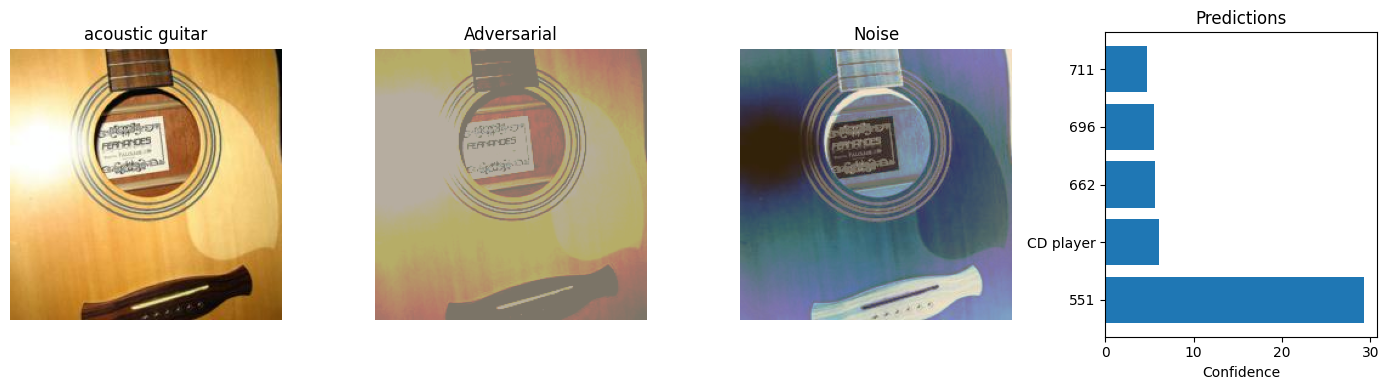

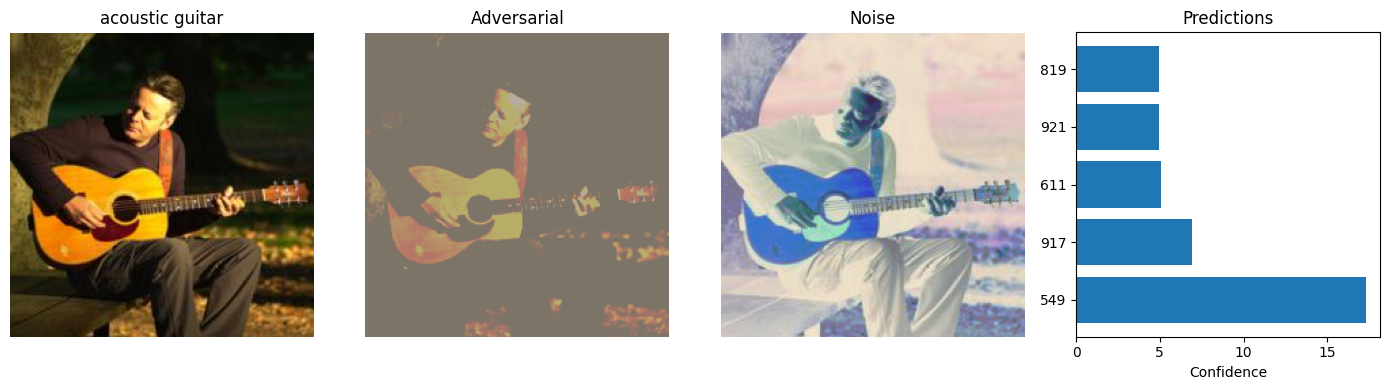

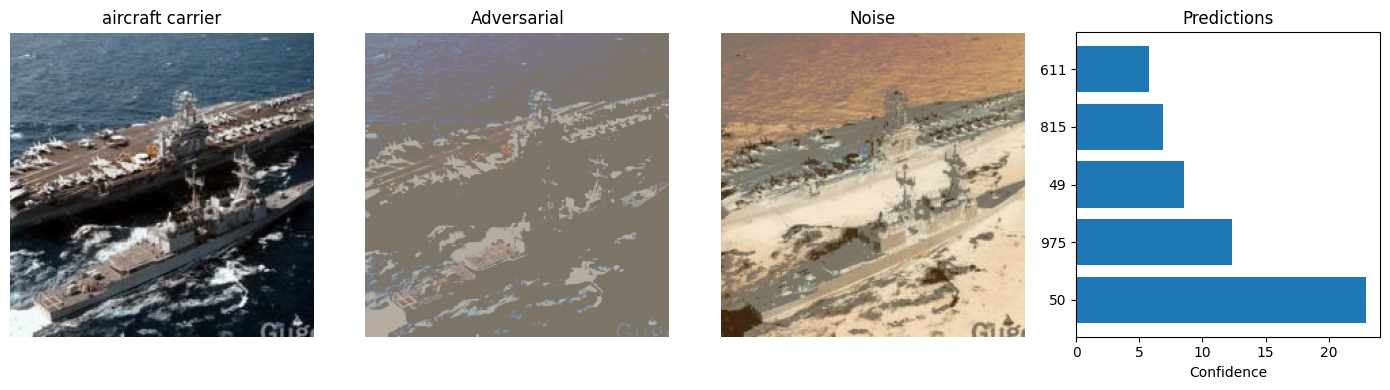

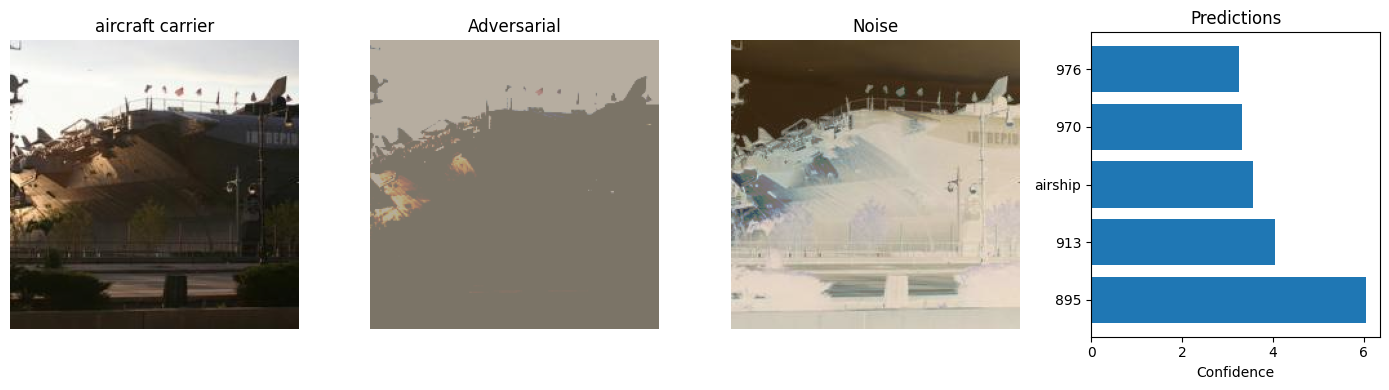

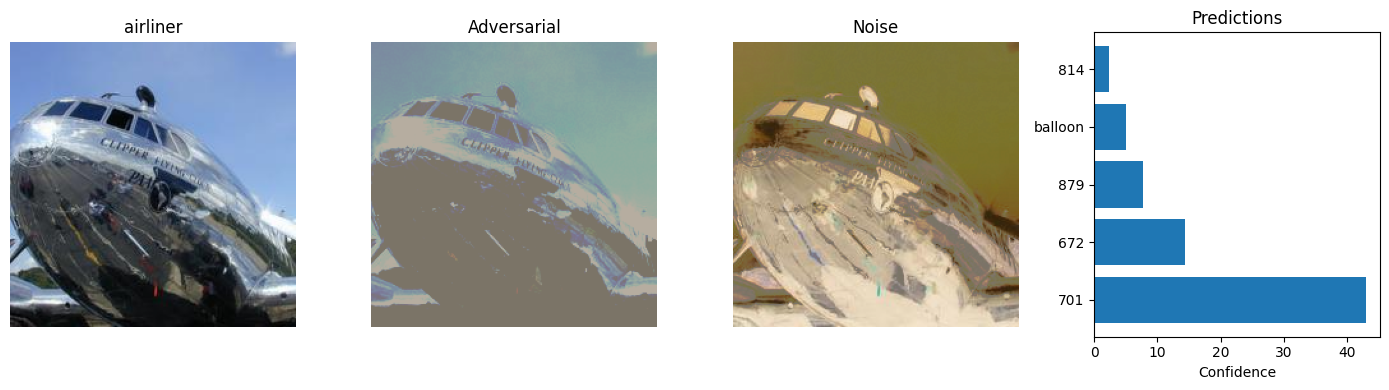

After FGSM Attack: Top-1 = 26.40%, Top-5 = 50.60%


In [ ]:
print("Evaluating original model...")
# top1_orig, top5_orig = evaluate(model, dataloader)

top1_orig, top5_orig = evaluate(
    model,
    dataloader,
    adversarial=False,
    structured_save=False,
)
print(f"Original Accuracy: Top-1 = {top1_orig:.2f}%, Top-5 = {top5_orig:.2f}%")

print("\nApplying FGSM attack...")
# top1_fgsm, top5_fgsm = evaluate(model, dataloader, adversarial=True, idx_to_label=idx_to_label)

top1_fgsm, top5_fgsm = evaluate(
    model,
    dataloader,
    adversarial=True,
    structured_save=True,
    original_root="./TestDataSet",
    structured_save_root="./adversarial_test_set_1",
    idx_to_label=idx_to_label,
    attack_function=fgsm_attack_1
)
print(f"After FGSM Attack: Top-1 = {top1_fgsm:.2f}%, Top-5 = {top5_fgsm:.2f}%")


Task 3


In [ ]:
# the attack function

def iterative_fgsm(model, image, label, epsilon=0.02, alpha=0.002, steps=10):
    # adv = image.clone().detach().to(device)
    # adv.requires_grad = True
    image = image.to(torch.float32)
    original_image = image.clone().detach()
    adv = original_image.clone().detach().requires_grad_(True)


    for _ in range(steps):
        outputs = model(adv)
        loss = nn.CrossEntropyLoss()(outputs, label)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            adv = adv + alpha * adv.grad.sign()
            perturbation = torch.clamp(adv - image, min=-epsilon, max=epsilon)
            adv = torch.clamp(image + perturbation, 0, 1).detach_()
            adv.requires_grad = True

    return adv

Running Improved Attack: I-FGSM ...


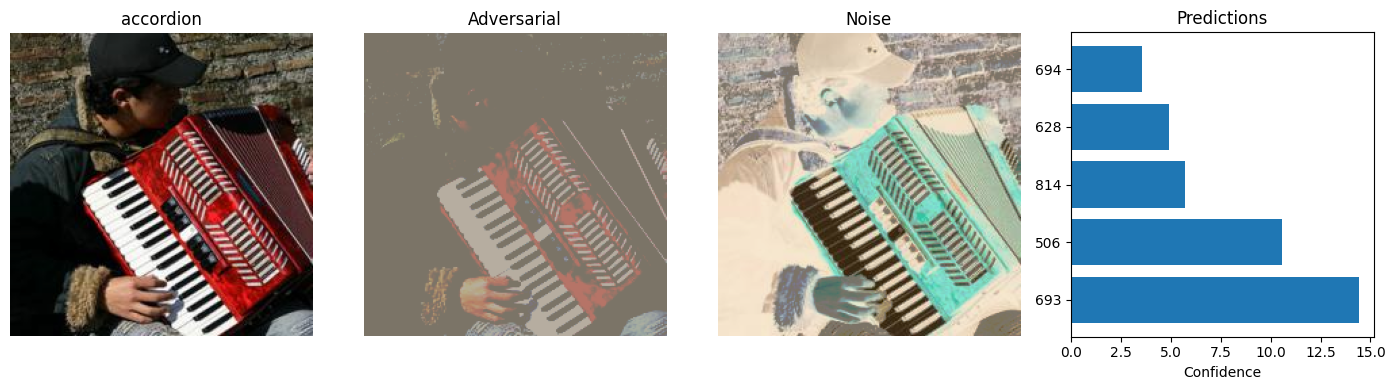

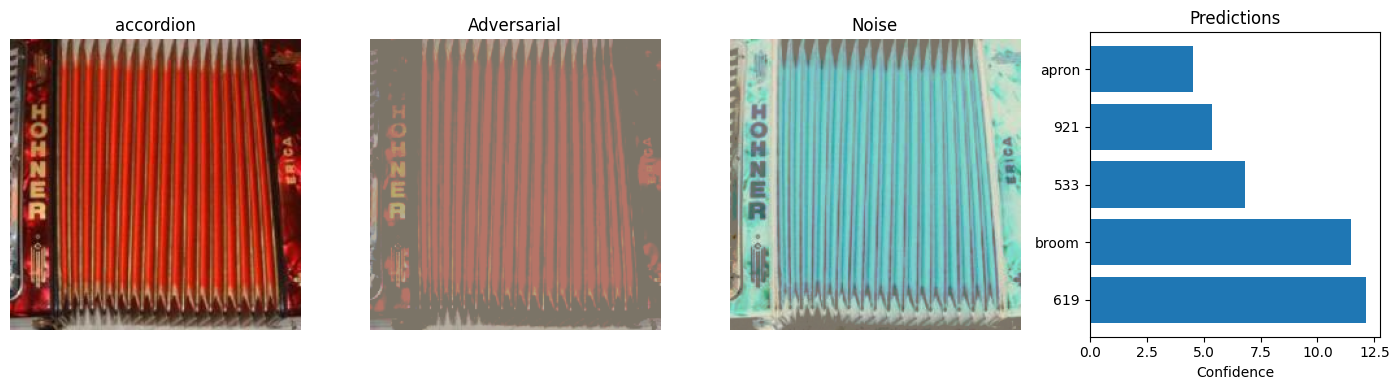

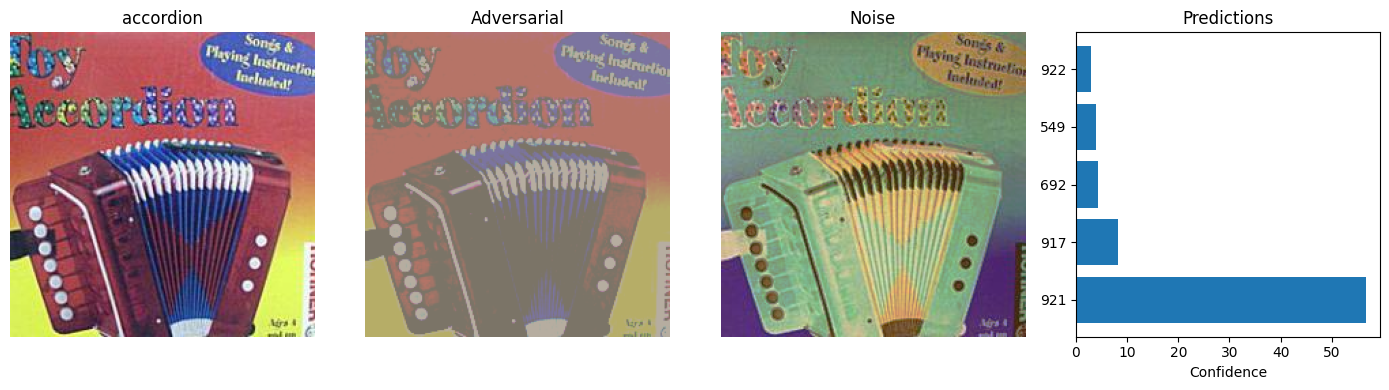

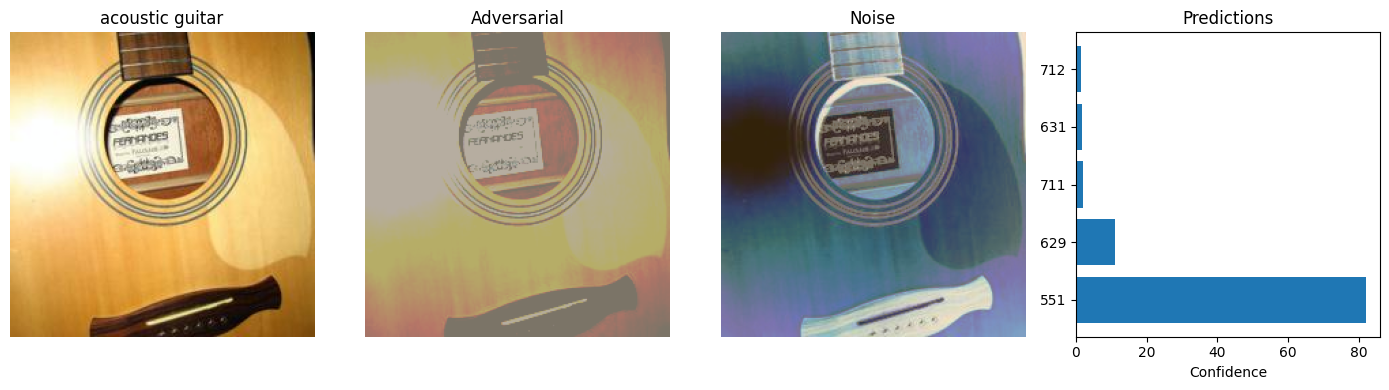

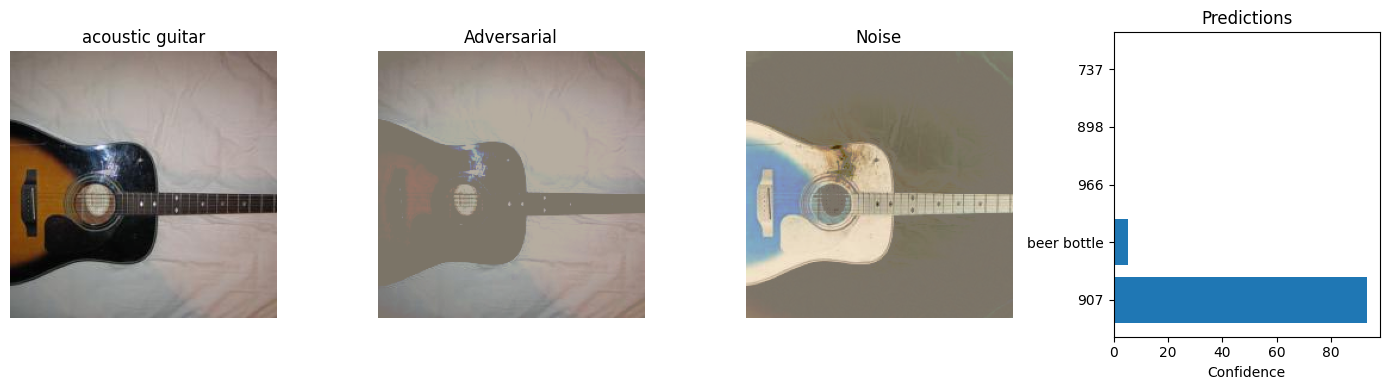

I-FGSM Attack Accuracy: Top-1 = 0.80%, Top-5 = 9.40%


In [ ]:
# run task 3
print("Running Improved Attack: I-FGSM ...")
# top1_adv2, top5_adv2 = evaluate_iterative_attack(model, dataloader, idx_to_label, index_to_name)

top1_adv2, top5_adv2 = evaluate(
    model,
    dataloader,
    adversarial=True,
    structured_save=True,
    original_root="./TestDataSet",
    structured_save_root="./adversarial_test_set_2",
    idx_to_label=idx_to_label,
    attack_function=iterative_fgsm
)
print(f"I-FGSM Attack Accuracy: Top-1 = {top1_adv2:.2f}%, Top-5 = {top5_adv2:.2f}%")


Task 4


In [ ]:
# attack funcition
def patch_fgsm_attack(model, image, label, epsilon=0.5, patch_size=32, targeted=True, target_class=401):
    adv = image.clone().detach().to(device)
    adv.requires_grad = True

    outputs = model(adv)
    loss = nn.CrossEntropyLoss()(outputs, torch.full_like(label, target_class) if targeted else label)
    model.zero_grad()
    loss.backward()
    grad = adv.grad.detach()

    # 选择 patch 起始坐标
    _, _, H, W = adv.shape
    x0 = np.random.randint(0, W - patch_size)
    y0 = np.random.randint(0, H - patch_size)

    perturb = epsilon * grad.sign()
    patch = perturb[:, :, y0:y0+patch_size, x0:x0+patch_size]

    # 仅替换 patch 区域
    with torch.no_grad():
      adv[:, :, y0:y0+patch_size, x0:x0+patch_size] = torch.clamp(
          adv[:, :, y0:y0+patch_size, x0:x0+patch_size] + patch, 0, 1
      )

    return adv.detach()


def patch_fgsm_attack_iterative(model, image, label, epsilon=0.5,
                          patch_size=32, targeted=True, target_class=401, steps=20,momentum=0.9):
    adv = image.clone().detach().to(device)
    adv.requires_grad = True
    accumulated_grad = torch.zeros_like(adv)

    for _ in range(steps):
      outputs = model(adv)
      loss = nn.CrossEntropyLoss()(outputs, torch.full_like(label, target_class) if targeted else label)
      model.zero_grad()
      loss.backward()
      grad = adv.grad.detach()
      accumulated_grad = momentum * accumulated_grad + grad / torch.norm(grad, p=1)  # L1 norm
      perturb = epsilon * accumulated_grad.sign()

    # 选择 patch 起始坐标
    _, _, H, W = adv.shape
    x0 = np.random.randint(0, W - patch_size)
    y0 = np.random.randint(0, H - patch_size)

    perturb = epsilon * grad.sign()
    patch = perturb[:, :, y0:y0+patch_size, x0:x0+patch_size]

    # 仅替换 patch 区域
    with torch.no_grad():
      adv[:, :, y0:y0+patch_size, x0:x0+patch_size] = torch.clamp(
          adv[:, :, y0:y0+patch_size, x0:x0+patch_size] + patch, 0, 1
      )

    return adv.detach()


In [ ]:
def iterative_patch_attack(
    model,
    image,
    label,
    epsilon=0.3,
    patch_size=64,
    alpha=0.05,
    steps=5,
    targeted=True,
    target_class=999
):
    image = image.clone().detach().to(torch.float32).to(device)
    original = image.clone().detach()

    B, C, H, W = image.shape
    x0 = np.random.randint(0, W - patch_size)
    y0 = np.random.randint(0, H - patch_size)

    adv = image.clone().detach()

    for _ in range(steps):
        adv.requires_grad = True
        outputs = model(adv)

        loss = torch.nn.CrossEntropyLoss()(
            outputs,
            torch.full_like(label, target_class) if targeted else label
        )
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad = adv.grad.detach()
            patch_grad = grad[:, :, y0:y0+patch_size, x0:x0+patch_size]
            patch = alpha * patch_grad.sign()

            adv_patch = adv[:, :, y0:y0+patch_size, x0:x0+patch_size] + patch
            adv_patch = torch.clamp(adv_patch, 0, 1)

            adv[:, :, y0:y0+patch_size, x0:x0+patch_size] = adv_patch
            adv = adv.detach()

    return adv

def generate_structured_adversarial_dataset(
    model,
    dataloader,
    save_root,
    original_root,
    epsilon=0.3,
    patch_size=64,
    steps=5,
    alpha=0.05,
    targeted=True,
    target_class=999
):
    model.eval()
    os.makedirs(save_root, exist_ok=True)

    with torch.no_grad():
        for images, labels, paths in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            adv_images = iterative_patch_attack(
                model=model,
                image=images,
                label=labels,
                epsilon=epsilon,
                patch_size=patch_size,
                alpha=alpha,
                steps=steps,
                targeted=targeted,
                target_class=target_class
            )

            for img, orig_path in zip(adv_images, paths):
                rel_path = os.path.relpath(orig_path, start=original_root)
                save_path = os.path.join(save_root, rel_path)
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                save_image(img.clamp(0, 1), save_path)

    print(f" Adversarial dataset saved to: {save_root}")



In [ ]:
# run task 4
print("Running Patch Attack Evaluation...")
# top1_patch, top5_patch = evaluate_patch_attack(model, dataloader, idx_to_label, index_to_name, epsilon=0.3, targeted=True)

top1_patch, top5_patch = evaluate(
    model,
    dataloader,
    adversarial=True,
    structured_save=True,
    original_root="./TestDataSet",
    structured_save_root="./adversarial_test_set_3",
    idx_to_label=idx_to_label,
    attack_function=patch_fgsm_attack_iterative
)

print(f"Patch Attack Accuracy: Top-1 = {top1_patch:.2f}%, Top-5 = {top5_patch:.2f}%")


Running Patch Attack Evaluation...
Patch Attack Accuracy: Top-1 = 75.40%, Top-5 = 94.20%


Task 5

In [ ]:
# load the model DenseNet-1211
import torchvision.models as models

# 加载迁移评估用模型（非 ResNet-34）
transfer_model = models.densenet121(weights='IMAGENET1K_V1').to(device)
transfer_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# the eval
def evaluate_all(
    model,
    dataloader,
    adversarial=False,
    idx_to_label=None,
    structured_save=False,
    original_root=None,
    structured_save_root=None,
    SAVE_PATH="./adversarial_flat",
    EPSILON=0.02,
    attack_function=fgsm_attack_1,
):
    correct_1 = 0
    correct_5 = 0
    total = 0
    all_adv_images = []
    adv_image_count = 0
    failures_shown = 0

    model.eval()


    with torch.no_grad() if not adversarial else torch.enable_grad():
        for  (images, labels, paths) in loader:
            images, labels = images.to(device), labels.to(device)
            imagenet_labels = labels + 401  # or replace with mapped labels

            # Model prediction
            outputs = model(images)
            _, pred = outputs.topk(5, 1, True, True)
            correct = pred.eq(imagenet_labels.view(-1, 1).expand_as(pred))
            correct_1 += correct[:, 0].sum().item()
            correct_5 += correct.any(1).sum().item()
            total += labels.size(0)

    top1 = 100. * correct_1 / total
    top5 = 100. * correct_5 / total
    return top1, top5

def evaluate_all_1(
    model,
    dataloader,
    original_loader,
    adversarial=False,
    idx_to_label=None,
    structured_save=False,
    original_root=None,
    structured_save_root=None,
    SAVE_PATH="./adversarial_flat",
    EPSILON=0.02,
    attack_function=fgsm_attack_1,
):
    correct_1 = 0
    correct_5 = 0
    total = 0
    all_adv_images = []
    adv_image_count = 0
    failures_shown = 0

    model.eval()


    with torch.no_grad() if not adversarial else torch.enable_grad():
        for  (adv_image, adv_labels, adv_paths),(images, labels, paths) in zip(loader, original_loader):
            adv_image, labels = adv_image.to(device), labels.to(device)
            imagenet_labels = labels + 401  # or replace with mapped labels

            # Model prediction
            outputs = model(adv_image)
            _, pred = outputs.topk(5, 1, True, True)
            correct = pred.eq(imagenet_labels.view(-1, 1).expand_as(pred))
            correct_1 += correct[:, 0].sum().item()
            correct_5 += correct.any(1).sum().item()
            total += labels.size(0)

    top1 = 100. * correct_1 / total
    top5 = 100. * correct_5 / total
    return top1, top5

In [ ]:
# load datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

batch_size = 32

datasets = {
    "Original": ImageFolderWithPaths("./TestDataSet", transform=transform),
    "FGSM": ImageFolderWithPaths("./adversarial_test_set_1", transform=transform),
    "I-FGSM": ImageFolderWithPaths("./adversarial_test_set_2", transform=transform),
    "Patch": ImageFolderWithPaths("./adversarial_test_set_3", transform=transform),
}

dataloaders = {
    name: DataLoader(ds, batch_size=32, shuffle=False)
    for name, ds in datasets.items()
}

In [ ]:
# run eval
results = {}


for name, loader in dataloaders.items():
    print(f"\n Evaluating on {name} dataset using DenseNet-121...")
    # top1, top5 = evaluate_all(
    #     transfer_model,
    #     loader,
    #     adversarial=False,
    #     structured_save=False,

    # )
    top1, top5 = evaluate_all_1(
        transfer_model,
        loader,
        original_loader=dataloader,
        adversarial=False,
        structured_save=False,

    )
    results[name] = (top1, top5)
    print(f"Accuracy: Top-1 = {top1:.2f}%, Top-5 = {top5:.2f}%")



 Evaluating on Original dataset using DenseNet-121...
Accuracy: Top-1 = 74.60%, Top-5 = 93.60%

 Evaluating on FGSM dataset using DenseNet-121...
Accuracy: Top-1 = 38.20%, Top-5 = 60.80%

 Evaluating on I-FGSM dataset using DenseNet-121...
Accuracy: Top-1 = 38.80%, Top-5 = 59.40%

 Evaluating on Patch dataset using DenseNet-121...
Accuracy: Top-1 = 73.60%, Top-5 = 93.00%


In [ ]:
# the outputs
print("\n Accuracy Summary (Transfer Evaluation on DenseNet-121):")
print(f"{'Dataset':<15} {'Top-1 (%)':>10} {'Top-5 (%)':>10}")
for name, (top1, top5) in results.items():
    print(f"{name:<15} {top1:>10.2f} {top5:>10.2f}")



 Accuracy Summary (Transfer Evaluation on DenseNet-121):
Dataset          Top-1 (%)  Top-5 (%)
Original             74.60      93.60
FGSM                 38.20      60.80
I-FGSM               38.80      59.40
Patch                73.60      93.00


Not a large decreast from FGSM to iterative FGSM for DenseNet-121.
Finding: DenseNet-121 is robust, since the decrease in acc is not large even for the I-FGSM attack.